#### Outline.
            1. Word Embedding: using Frequency Base method
            
            2. Word Embedding: Prediction Base method step by step.
            
            3. Word Embedding: using Word2vec & GloVe
            
            4. Using Keras Embedding Layer in some example of real-dataset.

In [1]:
import numpy as np
import pandas as pd

**`Word embedding`** is the collective name for a set of **`language modeling`** and **`feature learning`** techniques in **`Natural language processing (NLP)`** where `words` or `phrases` from the `vocabulary` are *mapped to vectors of real numbers*. 

Conceptually, it involves a `mathematical embedding` from a space with `many dimensions per word` to a `continuous vector space` with a much `lower dimension`.

Methods to generate this mapping include `neural networks`, `dimensionality reduction` on the `co-occurrence matrix.`

There are two different model architectures which can be leveraged by `Word2Vec` to create these word embedding representations; includes: `Continuous Bag of Words (CBOW)` and `Skip-gram`. Hence, before understanding `Word2Vec`; we will explore the `CBOW` and `skip-gram` in the section 2 `Prediction Base method`.

The `GloVe (Global Vectorizer)` is an improvement from `Co-occurrence Matrix` which be presented in the following section.


## 1. Word Embedding: using Frequency Base method

Includes: `Count Vector`; `tf-idf Vector` and `Co-occurrence Matrix.`

### 1.1. CountVectorizer using with `TfidfTransformer` 

First, consider the simple sentences.

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = ['this is the first document',
          'this document is the second document',
          'and this is the third one',
          'is this the first document?',
          'this Document is not yours..']

cvect = CountVectorizer()
X = cvect.fit_transform(corpus)

print("There are %d sentences in this corpus"%(X.shape[0]))
print('The number of the different words is :', X.shape[1], ", and ... they are:")
print(cvect.get_feature_names())

There are 5 sentences in this corpus
The number of the different words is : 11 , and ... they are:
['and', 'document', 'first', 'is', 'not', 'one', 'second', 'the', 'third', 'this', 'yours']


- Firstly, they will count how many `different words` in this sentence, here are `11`; noting that both of the words "`document`" and "`Document`" will be changed to the lower scripts : `"Document"`.
- Only the second document contains the `word has frequencies = 2`, it is `document`.
- The `unique` words in the corpus will be arranged to the `English alphabet characters`; starting at the word "**a**nd" and ending by "**y**ours".
- The `punctuation` (such as `"?"` or `"!"`, ....) will be ignored.



In [3]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

vocabulary = cvect.get_feature_names()
pipe = Pipeline([('count', CountVectorizer(vocabulary = vocabulary, min_df=2, max_df=0.5, ngram_range=(1,2))),
                 ('tfid', TfidfTransformer(smooth_idf=False, use_idf=True))]).fit(corpus)
pipe['count'].transform(corpus).toarray()

array([[0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0],
       [0, 2, 0, 1, 0, 0, 1, 1, 0, 1, 0],
       [1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0],
       [0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1]], dtype=int64)

Next, **compute the `IDF` values.** (An `idf` is constant per corpus, and **accounts** for the ratio of documents that include the word.)

In [4]:
table = pd.DataFrame({"fea_names": cvect.get_feature_names(), "idf_smooth_False)": pipe['tfid'].idf_})
table

,fea_names,idf_smooth_False)
0,and,2.609438
1,document,1.223144
2,first,1.916291
3,is,1.000000
4,not,2.609438
5,one,2.609438
6,second,2.609438
7,the,1.223144
8,third,2.609438
9,this,1.000000


According to https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/feature_extraction/text.py#L987-L992 and https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html?highlight=tfidf#sklearn.feature_extraction.text.TfidfTransformer

- If `smooth_idf=False`); the formula that is used to compute the `tf-idf` for a term t of a document `d` in a document set is 

                                    tf-idf(w, d) = tf(w, d) * idf(w), 

and the `idf` is computed as 

                                        idf(w) = log [ n / df(w) ] + 1, 

where `n` is the `total number of documents in the corpus` and `df(t) is the document frequency of w`; the document frequency is the number of documents in the document set that contain the word `w`. 

The effect of adding `“1”` to the idf in the equation above is that terms with zero idf, i.e., terms that occur in all documents in a training set, ***will not be entirely ignored***. 

For example: 
1. The word `"is"`. We have a corpus of `5 sentences/ documents` and all of them contain this word (`"is"`); so 

                                    idf("is") = log(5 / 5) + 1 = 1

2. The word `"and"`, we have

                                    idf("and") = log(5 / 1) + 1 appox 2.609 
                                
Noting that, the `log` here is `natural logarithm (default)`.

***Note that the `idf` formula above differs from the standard textbook notation that defines the idf as***

                                    idf(w) = log [ n / (df(w) + 1) ].

- If `smooth_idf=True` (the default), the constant `“1”` is added to the numerator and denominator of the idf as if an extra document was seen containing every term in the collection exactly once, which ***prevents zero divisions:*** 

                                    idf(d, t) = log [ (1 + n) / (1 + df(d, t)) ] + 1.

In [5]:
pipe = Pipeline([('count', CountVectorizer(vocabulary = vocabulary, 
                                           min_df=2, max_df=0.5, ngram_range=(1,2))),
                 ('tfid', TfidfTransformer(smooth_idf=True, use_idf=True))]).fit(corpus)

table["idf_smooth_True"] = pipe['tfid'].idf_
table

,fea_names,idf_smooth_False),idf_smooth_True
0,and,2.609438,2.098612
1,document,1.223144,1.182322
2,first,1.916291,1.693147
3,is,1.000000,1.000000
4,not,2.609438,2.098612
5,one,2.609438,2.098612
6,second,2.609438,2.098612
7,the,1.223144,1.182322
8,third,2.609438,2.098612
9,this,1.000000,1.000000


In [6]:
## verify the idf_value of the word "and"

np.log(5) + 1, np.log((1 + 5)/(1+1))+1

(2.6094379124341005, 2.09861228866811)

**Compute the TFIDF score**, depend on how we compute the `idf_values`, the `tfidf` is defined by

                                tf-idf(w, d) = tf(w, d) * idf(w)

Recall that; the meaning of `TF` is **`term frequency`** and here defined by *the number of times that word `w` occurs in document `d`*

For example; in the first sentence, `d = 1`; the word `"and"` is not in this sentence, so `tf("and", d=1) = 0`.

See the table bellow.

In [7]:
vocabulary = cvect.get_feature_names()
pipe = Pipeline([('count', CountVectorizer(vocabulary = vocabulary, 
                                           min_df=2, max_df=0.5, ngram_range=(1,2))),
                 ('tfid', TfidfTransformer(smooth_idf=True, use_idf = True))]).fit(corpus)

count_vector = pipe['count'].transform(corpus).toarray()  ## equivalent with CountVectorizer.fit_transform(corpus)

tf_idf_vector = pipe['tfid'].transform(count_vector)
tf_idf_vector[0].toarray()
table["tfidf_smooth_True_1st_doc"] = tf_idf_vector[0].T.toarray()
table["tfidf_smooth_True_2nd_doc"] = tf_idf_vector[1].T.toarray()
table["tfidf_smooth_True_3rd_doc"] = tf_idf_vector[2].T.toarray()
table

,fea_names,idf_smooth_False),idf_smooth_True,tfidf_smooth_True_1st_doc,tfidf_smooth_True_2nd_doc,tfidf_smooth_True_3rd_doc
0,and,2.609438,2.098612,0.000000,0.000000,0.514923
1,document,1.223144,1.182322,0.427120,0.646126,0.000000
2,first,1.916291,1.693147,0.611659,0.000000,0.000000
3,is,1.000000,1.000000,0.361255,0.273244,0.245363
4,not,2.609438,2.098612,0.000000,0.000000,0.000000
5,one,2.609438,2.098612,0.000000,0.000000,0.514923
6,second,2.609438,2.098612,0.000000,0.573434,0.000000
7,the,1.223144,1.182322,0.427120,0.323063,0.290099
8,third,2.609438,2.098612,0.000000,0.000000,0.514923
9,this,1.000000,1.000000,0.361255,0.273244,0.245363


### 1.2. `TfidfVectorizer` is equivalent to the first method

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer()
tfidf_matrix =  tf.fit_transform(corpus)
feature_names = tf.get_feature_names()
print(feature_names)

['and', 'document', 'first', 'is', 'not', 'one', 'second', 'the', 'third', 'this', 'yours']


**Viewing the `tfidf-score` by using `TfidfVectorizer`; first looking at the `tfidf-values` in the first sentences.**

In [9]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(corpus)
M = tfidf_vectorizer_vectors.toarray()
M[0,:]

array([0.        , 0.42712001, 0.6116585 , 0.36125537, 0.        ,
       0.        , 0.        , 0.42712001, 0.        , 0.36125537,
       0.        ])

**tf-idf values using Tfidfvectorizer**

In [10]:
pd.DataFrame({"fea_names": feature_names, 
              "tfidf_TfVec_1st_doc": M[0, :], 
              "tfidf_TfVec_2nd_doc": M[1, :],
              "tfidf_TfVec_3rd_doc": M[2, :]})

,fea_names,tfidf_TfVec_1st_doc,tfidf_TfVec_2nd_doc,tfidf_TfVec_3rd_doc
0,and,0.000000,0.000000,0.514923
1,document,0.427120,0.646126,0.000000
2,first,0.611659,0.000000,0.000000
3,is,0.361255,0.273244,0.245363
4,not,0.000000,0.000000,0.000000
5,one,0.000000,0.000000,0.514923
6,second,0.000000,0.573434,0.000000
7,the,0.427120,0.323063,0.290099
8,third,0.000000,0.000000,0.514923
9,this,0.361255,0.273244,0.245363


In a summary, the main difference between the two modules are as follows:

- With `Tfidftransformer` you will systematically compute word counts using `CountVectorizer` and then compute the `Inverse Document Frequency (IDF)` values and only then compute the `Tf-idf scores`.

- With `Tfidfvectorizer` on the contrary, **you will do all three steps at once**. It computes the word counts, IDF values, and Tf-idf scores all using the same dataset.

**When to use what?**
So now you may be wondering, why you should use more steps than necessary if you can get everything done in two steps. Well, there are cases where you want to use Tfidftransformer over Tfidfvectorizer and it is sometimes not that obvious. Here is a general guideline:

- If you need the `term frequency` (term count) vectors for `different tasks`, use `Tfidftransformer`.
- If you need to compute `tf-idf scores` on documents within your `“training”` dataset, use `Tfidfvectorizer`.
- If you need to compute `tf-idf scores` on documents **`outside your “training”`** dataset, use either one, both will work.

-----------------------------------

In [11]:
import nltk
from nltk import bigrams
import itertools

However, the `disadvantage` of both preceding methods is that it **only focuses on the frequency of occurrence of a word, leading to it having almost no contextual meaning**. Using **`co-occurrence matrix`** can solves that problem partially. 

------------------------

### 1.3. Co-occurrence Matrix.

------------------------

**Definition.** `Co-occurrence matrix`, is a symmetric square matrix, each row or column will be the vector representing the corresponding word; it is measuring `co-occurrences` of `features` within a `user-defined context`. 

The `context` can be defined as a document or a `window` within a collection of documents, with an `optional vector of weights` applied to the co-occurrence counts.

------------------------

Hence, **`Co-occurrence Matrix`** has the ***advantage of preserving the semantic relationship between words, built on the number of occurrences of word pairs in the `Context Window`***. 


`A Context Window` is determined by its size and direction, the following table is an example of the `Context Window` with `size = 1`. 
- Given a text_data:

            draft_text = [["I", "love", "you", "and", "hers"], 
                          ["Don't", "worried", "just", "kidding"], 
                           ["I", "love", "NLP"],
                           ["I", "love", "Machine", "Learning", "and", "Mathematics"]]


- We want to create the matrix $X$ such that $X_{i, j}$ represents how often `word_i` appears in `context_of_word_j`. For example, there are 3 times word `word_i = "love"` is defined by the words `word_j = "I"` in these `context_sentences`: "`I love` you and hers", "`I love` NLP" and "`I love` Machine Learning and Mathematics".

$$ X_{\text{("I", "love")}} = X_{\text{("love", "I")}} = 3 $$

In [77]:
## ------------------------- hiden code --------------------------------------

def generate_co_occurrence_matrix(corpus):
    
    ## Create the vocabulary_list, set and indexes
    vocab = set(corpus)
    vocab = list(vocab)
    vocab_index = {word: i for i, word in enumerate(vocab)}
 
    # Create bigrams from all words in corpus
    bi_grams = list(bigrams(corpus))
 
    # Frequency distribution of bigrams ((word1, word2), num_occurrences)
    bigram_freq = nltk.FreqDist(bi_grams).most_common(len(bi_grams))
 
    # Initialise co-occurrence matrix
    # co_occurrence_matrix[current][previous]
    co_occurrence_matrix = np.zeros((len(vocab), len(vocab)))
 
    # Loop through the bigrams taking the current and previous word (one-way),
    # and the number of occurrences of the bigram.
    for bigram in bigram_freq:
        current = bigram[0][1]
        previous = bigram[0][0]
        count = bigram[1]
        pos_current = vocab_index[current]
        pos_previous = vocab_index[previous]
        co_occurrence_matrix[pos_current][pos_previous] = count
    
    # create a symetric matrix by combining it to its transpose to get the two-way
    co_occurrence_matrix = np.matrix(co_occurrence_matrix + co_occurrence_matrix.T)
 
    # return the matrix and the index
    return co_occurrence_matrix, vocab_index

draft_text = [["I", "love", "you", "and", "hers"], 
              ["Don't", "worried", "just", "kidding"], 
              ["I", "love", "NLP"],
              ["I", "love", "Machine", "Learning", "and", "Mathematics"]]
data = list(itertools.chain.from_iterable(draft_text))
matrix, vocab_index = generate_co_occurrence_matrix(data)
  
data_matrix = pd.DataFrame(matrix, index=vocab_index,
                             columns=vocab_index)
data_matrix

,kidding,I,and,worried,Learning,Machine,Mathematics,just,hers,love,NLP,Don't,you
kidding,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
I,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0
and,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
worried,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
Learning,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Machine,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Mathematics,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
just,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hers,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
love,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


with the `window_size = 1`, then using `bi-grams` is a `sensible way` to build this matrix. The `detailed-discussion` on **`Bi-grams` and `N-grams`** will be introduced later in this link:

https://github.com/Nhan121/Lectures_notes-teaching-in-VN-/blob/master/Statistics/NLP/N-grams%20NLP.ipynb

**Quick reminder: Bigrams**

- A `bigram` or `digram` is a sequence of 2 `adjacent elements` from a `string of tokens`, which are typically `letters`, `syllables`, or `words`.

-  The `frequency distribution` of every bigram in a string is commonly used for simple `statistical analysis of text` in many `applications`, such as `computational linguistics`, `cryptography`, `speech recognition`.

- Bigrams help provide the `conditional probability` of a `token` given the **`preceding token`**, when the relation of the conditional probability is applied:

$$ \mathbb{P}\left( \text{token}_{k} \left\vert \text{token}_{k-1}\right. \right) = \dfrac{\mathbb{P}\left( \text{token}_{k}, \text{token}_{k-1} \right)}{ \mathbb{P} \left( \text{token}_{k-1} \right)} $$

For example, the sentence `"The office building was destroyed yesterday"` contains 5 `bigrams`:
        
        the office, office building, building was, was destroyed, destroyed yesterday.

In [13]:
sentence = "The office building was destroyed yesterday"
bi_grams = list(bigrams(sentence.split()))
bi_grams

[('The', 'office'),
 ('office', 'building'),
 ('building', 'was'),
 ('was', 'destroyed'),
 ('destroyed', 'yesterday')]

Before build-in a function for the `co_occurrence_matrix`; we will use a few classes and packages; Firstly 

**Insight coding**
Use `itertools.chain.from_iterable`

In [14]:
draft_text = [["I", "love", "you", "and", "hers"], 
              ["Don't", "worried", "just", "kidding"], 
              ["I", "love", "NLP"],
              ["I", "love", "Machine", "Learning", "and", "Mathematics"]]

z = itertools.chain.from_iterable(draft_text)
z

**put the `object: itertools.chain` to list, then we get an 1D vector**

In [15]:
data = list(z)
print(data)

['I', 'love', 'you', 'and', 'hers', "Don't", 'worried', 'just', 'kidding', 'I', 'love', 'NLP', 'I', 'love', 'Machine', 'Learning', 'and', 'Mathematics']


**Create the vocabulary_list, set and indexes**

In [16]:
vocab = set(data)
vocab = list(data)
print(vocab)

['I', 'love', 'you', 'and', 'hers', "Don't", 'worried', 'just', 'kidding', 'I', 'love', 'NLP', 'I', 'love', 'Machine', 'Learning', 'and', 'Mathematics']


In [17]:
len(vocab)

18

In [18]:
vocab_index = {word: i for i, word in enumerate(vocab)}
vocab_index

{'I': 12,
 'love': 13,
 'you': 2,
 'and': 16,
 'hers': 4,
 "Don't": 5,
 'worried': 6,
 'just': 7,
 'kidding': 8,
 'NLP': 11,
 'Machine': 14,
 'Learning': 15,
 'Mathematics': 17}

This meant the last time the word appear in the whole sentences. 

For example the last time the word `Mathematics` appears in the data is `18 (index = 17 in python)` while the word `love` is `14 (index = 13)`; you is `3 (index = 2)`.

-------------------------------

**Create bigrams from all words in corpus**

In [19]:
bi_grams = list(bigrams(data))
print(bi_grams)

[('I', 'love'), ('love', 'you'), ('you', 'and'), ('and', 'hers'), ('hers', "Don't"), ("Don't", 'worried'), ('worried', 'just'), ('just', 'kidding'), ('kidding', 'I'), ('I', 'love'), ('love', 'NLP'), ('NLP', 'I'), ('I', 'love'), ('love', 'Machine'), ('Machine', 'Learning'), ('Learning', 'and'), ('and', 'Mathematics')]


***Count the bigrams***

In [20]:
bigram_freq = nltk.FreqDist(bi_grams).most_common(len(bi_grams))
bigram_freq

[(('I', 'love'), 3),
 (('love', 'you'), 1),
 (('you', 'and'), 1),
 (('and', 'hers'), 1),
 (('hers', "Don't"), 1),
 (("Don't", 'worried'), 1),
 (('worried', 'just'), 1),
 (('just', 'kidding'), 1),
 (('kidding', 'I'), 1),
 (('love', 'NLP'), 1),
 (('NLP', 'I'), 1),
 (('love', 'Machine'), 1),
 (('Machine', 'Learning'), 1),
 (('Learning', 'and'), 1),
 (('and', 'Mathematics'), 1)]

Noting that; the `bigram_freq` now is the list of the `tupple`. 

For instance; the first element in this list is the `tupple: (('I', 'love'), 3)` is combined by the `set: ('I', 'love')` and an  `integer: 3`

In [21]:
type(bigram_freq), type(bigram_freq[1]), type(bigram_freq[0][1])

(list, tuple, int)

NOW, assigning the `current(word) = bigram[0][1]` and the `previous(preceding word) = bigram[0][0]` for each iterations `bigram in bigram_freq`

In [22]:
co_occurrence_matrix = np.zeros((len(vocab), len(vocab)))
for bigram in bigram_freq:
    current = bigram[0][1]   ## row 1 ([0]); col 2 ([1]) of the first set in the 2D-set
    previous = bigram[0][0]  ## row 1, col 1
    count = bigram[1]        ## the values in the 2nd set
    print(bigram, '\t\t', current, "\t\t", previous, "\t\t",count)

(('I', 'love'), 3) 		 love 		 I 		 3
(('love', 'you'), 1) 		 you 		 love 		 1
(('you', 'and'), 1) 		 and 		 you 		 1
(('and', 'hers'), 1) 		 hers 		 and 		 1
(('hers', "Don't"), 1) 		 Don't 		 hers 		 1
(("Don't", 'worried'), 1) 		 worried 		 Don't 		 1
(('worried', 'just'), 1) 		 just 		 worried 		 1
(('just', 'kidding'), 1) 		 kidding 		 just 		 1
(('kidding', 'I'), 1) 		 I 		 kidding 		 1
(('love', 'NLP'), 1) 		 NLP 		 love 		 1
(('NLP', 'I'), 1) 		 I 		 NLP 		 1
(('love', 'Machine'), 1) 		 Machine 		 love 		 1
(('Machine', 'Learning'), 1) 		 Learning 		 Machine 		 1
(('Learning', 'and'), 1) 		 and 		 Learning 		 1
(('and', 'Mathematics'), 1) 		 Mathematics 		 and 		 1


**Build-in the function**

In [78]:
def generate_co_occurrence_matrix(corpus):
    
    ## Create the vocabulary_list, set and indexes
    vocab = set(corpus)
    vocab = list(vocab)
    vocab_index = {word: i for i, word in enumerate(vocab)}
 
    # Create bigrams from all words in corpus
    bi_grams = list(bigrams(corpus))
 
    # Frequency distribution of bigrams ((word1, word2), num_occurrences)
    bigram_freq = nltk.FreqDist(bi_grams).most_common(len(bi_grams))
 
    # Initialise co-occurrence matrix
    # co_occurrence_matrix[current][previous]
    co_occurrence_matrix = np.zeros((len(vocab), len(vocab)))
 
    # Loop through the bigrams taking the current and previous word (one-way),
    # and the number of occurrences of the bigram.
    for bigram in bigram_freq:
        current = bigram[0][1]
        previous = bigram[0][0]
        count = bigram[1]
        pos_current = vocab_index[current]
        pos_previous = vocab_index[previous]
        co_occurrence_matrix[pos_current][pos_previous] = count
    
    # create a symetric matrix by combining it to its transpose to get the two-way
    co_occurrence_matrix = np.matrix(co_occurrence_matrix + co_occurrence_matrix.T)
 
    # return the matrix and the index
    return co_occurrence_matrix, vocab_index

draft_data = list(itertools.chain.from_iterable(draft_text))
matrix, vocab_index = generate_co_occurrence_matrix(draft_data)
  
data_matrix = pd.DataFrame(matrix, index=vocab_index,
                             columns=vocab_index)
data_matrix

,kidding,I,and,worried,Learning,Machine,Mathematics,just,hers,love,NLP,Don't,you
kidding,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
I,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0
and,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
worried,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
Learning,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Machine,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Mathematics,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
just,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hers,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
love,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [81]:
text = [["I", "love", "Math", "." , "I", "love", "Programming", ".", "I", "love", "Biology"],
         ["I", "love", "Math", "and", "Programming", "and", "Biology"],
         ["I", "hate", "cat", "." , "I", "hate", "dog", "and", "snake"]]

# Create one list using many lists
data = list(itertools.chain.from_iterable(text))
matrix, vocab_index = generate_co_occurrence_matrix(data)
  
data_matrix = pd.DataFrame(matrix, index=vocab_index,
                             columns=vocab_index)
data_matrix

,snake,I,dog,Biology,and,.,cat,hate,Math,love,Programming
snake,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
I,0.0,0.0,0.0,2.0,0.0,3.0,0.0,2.0,0.0,4.0,0.0
dog,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
Biology,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
and,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
.,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
cat,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
hate,0.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Math,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0
love,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0


- Here the word `‘love’` is defined by the words `‘I’` and `‘Programming’`, meaning that we increment the value both for the `‘I love’` and the `‘love Programming’` co-occurrence. We do that for each window and obtain the preceding `co-occurrence matrix`.

- Since `‘Programming’` and `‘Math’` share the same co-occurrence values, they would be placed in the same place; meaning that in this context they mean the same thing (or `‘pretty much’` the same thing). `‘Biology’` would be the closest word to these 2 meaning ‘it has the closest possible meaning but it’s not the same thing’, and so on for every word. The semantic and syntactic relationships generated by this technique are really powerful but it’s computationally expensive since we are talking about a very high-dimensional space. Therefore, we need a technique that reduces dimensionality for us with the least data-loss possible.

----------------------------------
### Summarizations.

#### Advantages
- It preserves the `semantic relationship` between words.
- It uses `SVD (singular value decomposition)` at its core to reduce the size of vector, which produces more accurate word vector representations than existing methods.
- It uses `factorization` which is a `well-defined problem` and can be efficiently solved.
- It has to be computed once and can be used anytime once computed. In this sense, it is faster in comparison to others.

#### Disadvantage
The disadvantage of **`Co-occurrence Matrix (CM)`** is when the `text_data` contains a `large numbers of vocalbularies`; hence it requires huge memory to store the co-occurrence matrix. 

To make the representation of words clearer and save memory used to store **`CM`**; we have to choose or to remove some unnecessary words (such as **`stopwords`**).

--------------------------

## 2. Word Embedding: using Prediction Base method

In this section, we will study 2 models : `Continuous Bag of Words (CBOW)` and `skip-gram`. Both of them

### 2.1. `Continuous Bag of Words (CBOW)`:
`CBOW` is learning to predict the word by the context. A context may be single word or multiple word for a given target words.

The `CBOW model` architecture tries to predict the current target word (the center word) based on the source context words (surrounding words). 

------------------------------

Considering a simple sentence, `“the office building was destroyed yesterday”`, this can be pairs of (`context_window`, `target_word`) where if we consider a `context window of size = 2`, we have examples like (`[the, building]`, `office`), (`[was, yesterday]`, `destroyed`), (`[office, was]`, `building`) and so on.

Thus, the model ***tries to predict the target_word based on the context_window words***.

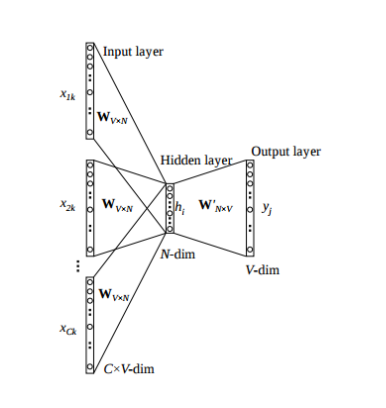

In [25]:
from IPython.core.display import Image, display

display(Image(r"C:\Users\Admin\Desktop\Nhan_pro\Data\cbow1.png", width=590, unconfined=True))
# https://github.com/Nhan121/Kaggle-6-first-projects/blob/master/NLP_Text_Classification/image_illustration/cbow1.png

**Describe problem using 3 layers: `Input`; `hidden (Lambda layer)` & `output`**

We breakdown the way this model works in these steps:
- $W_i$ is weight matrix between `input layer` and `hidden layer` of size `[V * N]`
- $W'$ is weight matrix between hidden layer and output layer of size `[N * V]`

Step 1) We need pairs which consist of a `target centre word` $x_c$ and surround context words; So we first generate our `one hot word vectors` 

                            (x (c−m) , . . . , x (c−1) , x (c+1) , . . . , x (c+m) )
            
for the input context of size m. where x(c) is the center or target word that we want to predict. we have `C = 2m` one hot word vector of size `[1 * V]`. So, our `input layer` size is `[C * V]`; the `hidden layer` is an $N$-dimensional vector $\textbf{h}$; and the `output layer` is output word in the training example which is also `one-hot encoded`. 

The one-hot encoded input vectors are connected to the hidden layer via a weight matrix and the `hidden layer` is connected to the output layer via a $N \times V$ wieght matrix $W'$.

Step 2) **[Forward Propagation]** Now we take average of these $2m $ vectors, shaped `[1 * N]` to evaluate the `output` of the `hidden layer` 
$$ \textbf{h} = \dfrac{1}{2m} W \circ \left( \sum_{i=1}^C x_i \right) := \dfrac{1}{C} \sum_{i=1}^C \textbf{v}_{\text{w}_i}^T $$

where $\textbf{v}_{\text{w}_i}^T$ is the `vector representation` of the `input word` $\text{w}_i$ (from the `input matrix` $W$).

Then compute the `inputs to each node in the output layer` $$ u_j = \textbf{v}'^T_{\textbf{w}_j} \circ \textbf{h} $$

where $\textbf{v}'_{\textbf{w}_j}$ is the $j^{th}$ column of the `output matrix` $W'$

Step 3) Next, Compute the output of the output layer by using the `soft-max` as an activation

$$ y_{j}=\mathbb{P}\left(\textbf{w}_{y_{j}}\left|\textbf{w}_{y_{1}},\ldots,\textbf{w}_{y_{C}}\right.\right)=\dfrac{\exp\left(u_{j}\right)}{\sum_{k=1}^{V}\exp\left(u_{k} \right)} $$

Since `input word` to the model be the `1-hot encoded vectors`, where the `size of the vector` is the `size of the vocabulary`; so we must have a **Quick reminder on `one-hot-encoder`.**  

`One-hot representation` is a method in which only one element is 1 and the other elements are 0 in the vector. By setting 1 or 0 for each dimension, it represents `“that word or not”`.

Let’s say, for example, we represent the word `“python”` as one-hot representation. Here, the vocabulary which is a set of words is 5 labels or words (`cold, python, hot, ruby, warm`). 

In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

data = ['warm', 'cold', 'cold', 'warm', 'cold', 'hot', 'ruby', 'cold', 'python']
values = np.array(data)
print('text data: ', values)

## label_encoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print('label for each class:', label_encoder.classes_)
print('integer encode:', integer_encoded)
print('inverse_trans:', [0, 0, 1, 3, 3, 4, 0, 1], '=', label_encoder.inverse_transform([0, 0, 1, 3, 3, 4, 0, 1]))

## one_hot_encoder
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print('binary encode: \n', onehot_encoded)
print('first word: ', label_encoder.inverse_transform([np.argmax(onehot_encoded[0, :])]))
print('second word: ', label_encoder.inverse_transform([np.argmax(onehot_encoded[1, :])]))
print('last word: ', label_encoder.inverse_transform([np.argmax(onehot_encoded[-1, :])]))

text data:  ['warm' 'cold' 'cold' 'warm' 'cold' 'hot' 'ruby' 'cold' 'python']
label for each class: ['cold' 'hot' 'python' 'ruby' 'warm']
integer encode: [4 0 0 4 0 1 3 0 2]
inverse_trans: [0, 0, 1, 3, 3, 4, 0, 1] = ['cold' 'cold' 'hot' 'ruby' 'ruby' 'warm' 'cold' 'hot']
binary encode: 
 [[0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
first word:  ['warm']
second word:  ['cold']
last word:  ['python']


**Learning the Weight Matrices with Backpropagation.** 

In the process of learning the wieght matrices $W_j$ and $W'$, we begin with randomly initialized values. We then sequentially feed training examples into our model and observe the error which is some function of the difference between the expected output and the actual output. 

We then compute the gradient of this error with respect to the elements of both weight matrices and correct them in the direction of this gradient. This general optimization procedure is known as **SGD** but the method by which the gradients are derived is known as **backpropagation**.

The first step is to define the loss function. The objective is to maximize the conditional probability of the output word given the input context, therefore our `loss function` as

$$ E = -\log p\left( \textbf{w}_{\text{Output}} \left| \textbf{w}_{\text{Input}} \right. \right)=-u_{j_{*}}  \log\sum_{k=1}^{V} \exp \left( u_{k}\right) = -\textbf{v}_{\textbf{w}_{\text{Output}}} \circ \textbf{h} -\log \sum_{k=1}^{V} \exp \left( \textbf{v}_{\textbf{w}_{k}}^{T} \circ \textbf{h}\right) $$

where $j_{*}$ is the `index` of the the **`actual output word`**. The next step is to derive the update equation for the hidden-output layer weights , then derive the weights for the input-hidden layer weights.

---------------------------

**Updating the `hidden-output layer` weights.**

The first step is to compute the derivative of the `loss function` w.r.t the `input` to the node $j^{th}$ in the output layer $u_j$:

$$ \dfrac{\partial E}{\partial u_j} = y_j - t_j $$

where $t_{j}=\delta_{jj_{*}}$. This is simply the `prediction error` of node $j$ in the `output layer`. 

Next, using the `chain rule` to find partial derivaties w.r.t the output-weight,

$$ \dfrac{ \partial E}{ \partial\text{w}_{ij}} = \dfrac{ \partial E}{\partial u_{j}} \dfrac{\partial u_{j}}{\partial \text{w}_{ij}} = \left(y_{j}-t_{j}\right) h_{i} $$

Using **SGD** for $\eta > 0$, we obtain
$$ \text{w}_{ij\left(\text{new}\right)}^{'}=\text{w}_{ij\left(\text{old}\right)}^{'}-\eta\left(y_{j}-t_{j}\right) h_{i} $$
and
$$ \textbf{v}'_{\textbf{w}_{j\left(\text{new}\right)}} = \textbf{v}'_{\textbf{w}_{j\left(\text{old}\right)}}-\eta\left(y_{j}-t_{j}\right)\textbf{h}. $$

**Updating the `input-hidden layer` weights.**

By the `chain-rule` again; we calculate the derivative of w.r.t an arbitrary hidden node $h_i$

$$ \dfrac{\partial E}{\partial h_{i}}=\sum_{j=1}^{V}\dfrac{\partial E}{\partial u_{j}}\dfrac{\partial u_{j}}{\partial h_{j}}=\sum_{j=1}^{V}\left(y_{j}-t_{j}\right)\text{w}'_{ij}$$

where the sum is do to the fact that the hidden layer node $h_{i}$ is connected to each node of the output layer and therefore each prediction error must be incorporated. The next step is to compute the derivative $E$ of with respect to an arbitrary input weight 

$$\text{w}_{ki}\dfrac{\partial E}{\partial\text{w}_{ki}}=\sum_{i=1}^{V}\dfrac{\partial E}{\partial h_{i}}\dfrac{\partial h_{i}}{\partial\text{w}_{ki}}=\sum_{i=1}^{V}\left(\left(y_{j}-t_{j}\right)\text{w}'_{ij}\right)\left(C^{-1}x_{k}\right)$$

hence, by SGD again

$$\textbf{v}_{\textbf{w}_{\text{Input, c}}}^{\text{(new)}'} = \textbf{v}_{\textbf{w}_{\text{Input, c}}}^{\text{(old)}'} - \eta C^{-1}\sum_{i=1}^{V}\left(y_{j}-t_{j}\right)\text{w}'_{ij}x_{k}$$

**Quick example for `keras.preprocessing.text.Tokenizer`**

In [27]:
from keras.preprocessing.text import Tokenizer
t  = Tokenizer()
fit_text = ["The earth is an awesome place live"]
t.fit_on_texts(fit_text)
test_text = ["The earth is a great place live"]
sequences = t.texts_to_sequences(test_text)
print("sequences : ", sequences,'\n')
print("word_index : ", t.word_index)

Using TensorFlow backend.


sequences :  [[1, 2, 3, 6, 7]] 

word_index :  {'the': 1, 'earth': 2, 'is': 3, 'an': 4, 'awesome': 5, 'place': 6, 'live': 7}


2 sentences has the `conciding_words`; for example:
- `the (index = 1)` is the first word in the first sentence (for fiting model)
- `earth (index =2)`
- and so on

#### Build the corpus vocabulary.

To start off, we will first build our corpus vocabulary where we **extract out each unique word from our vocabulary and map a unique numeric identifier to it**.

In [28]:
from keras.utils import np_utils
from keras.preprocessing import sequence

corpus2 = ['without loss of generality; we consider firstly on the unit ball',
          'this is the first document: the Earth is an great place live',
          'Likewise this document is the second document: the Earth is an awesome place live.',
          'and this is the third one: this problem does not hold the Slater condition',
          'is this the first document: Jane is not  fat and fast',
          'this Document is not yours: laid by her , and said unto Cain',
           'In the beginning God created heaven and earth',
           "next one is: the quick brown fox jumps over the lazy dog",
            'Finally, all of above are documents; the end']

tokenizer = Tokenizer(num_words = None, 
                           filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                           lower = True)
tokenizer.fit_on_texts(corpus2)

word_index = tokenizer.word_index
vocab_size = len(word_index)
print('Vocabulary Size:', vocab_size)
word_index

Vocabulary Size: 61


{'the': 1,
 'is': 2,
 'this': 3,
 'document': 4,
 'and': 5,
 'earth': 6,
 'not': 7,
 'of': 8,
 'first': 9,
 'an': 10,
 'place': 11,
 'live': 12,
 'one': 13,
 'without': 14,
 'loss': 15,
 'generality': 16,
 'we': 17,
 'consider': 18,
 'firstly': 19,
 'on': 20,
 'unit': 21,
 'ball': 22,
 'great': 23,
 'likewise': 24,
 'second': 25,
 'awesome': 26,
 'third': 27,
 'problem': 28,
 'does': 29,
 'hold': 30,
 'slater': 31,
 'condition': 32,
 'jane': 33,
 'fat': 34,
 'fast': 35,
 'yours': 36,
 'laid': 37,
 'by': 38,
 'her': 39,
 'said': 40,
 'unto': 41,
 'cain': 42,
 'in': 43,
 'beginning': 44,
 'god': 45,
 'created': 46,
 'heaven': 47,
 'next': 48,
 'quick': 49,
 'brown': 50,
 'fox': 51,
 'jumps': 52,
 'over': 53,
 'lazy': 54,
 'dog': 55,
 'finally': 56,
 'all': 57,
 'above': 58,
 'are': 59,
 'documents': 60,
 'end': 61}

This meant there are 61 vocalbularies in `corpus2`; the first vocabulary is the word has the highest frequency; here is an article `the`; the next one `is` and the last one is `end`.

#### Build vocabulary of unique words

In [29]:
from keras.preprocessing import text

## Re-arange the order in word_index as index : word
id_word = {v:k for k, v in word_index.items()}

## list of the index_words
wids = [[word_index[w] for w in text.text_to_word_sequence(doc, 
                                                           filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', 
                                                           lower = True, split=' ')] 
        for doc in corpus2]

embed_size = 10

print('Vocabulary Sample: \n', list(word_index.items())[:5])

Vocabulary Sample: 
 [('the', 1), ('is', 2), ('this', 3), ('document', 4), ('and', 5)]


--------------------------------------

Now, we can see that we have created a vocabulary of `unique words` in our `corpus` and also ways to map a word to `its unique identifier`. 

Take a look insight to understand `"How the previous command-line works?"`; To convenient, we consider the first documents in the `corpus2`; that is `corpus[0]`

Noting that **`text.text_to_word_sequence`** returns sequence of words (or tokens); so the `wids` contains the `word_index`

In [30]:
print(text.text_to_word_sequence(corpus2[0]))

['without', 'loss', 'of', 'generality', 'we', 'consider', 'firstly', 'on', 'the', 'unit', 'ball']


For example; the word `'without'` has index = 14; ..., `'ball'` has index = 22; so we recover a `list of index-word` for each sentence

In [31]:
[word_index[k] for k in text.text_to_word_sequence(corpus2[0])]

[14, 15, 8, 16, 17, 18, 19, 20, 1, 21, 22]

Obviously, the values of `wids[0]` or `wids[:1]` must be concided the preceding line

In [32]:
wids[:1]  ## this is wids[0]

[[14, 15, 8, 16, 17, 18, 19, 20, 1, 21, 22]]

Before going on to the `generating CBOW`; take a look to `sequence.pad_sequences` and  `np.utils.to_categorical`.

Again; focus on the first document

In [33]:
window_size = 2 # context window size
context_length = window_size*2
for words in wids[:1]:
    sentence_length = len(words)
    for index, word in enumerate(words):
        context_words = []
        label_word   = []            
        start = index - window_size
        end = index + window_size + 1
    
        context_words.append([words[i] 
                             for i in range(start, end) 
                             if 0 <= i < sentence_length 
                            and i != index])
        label_word.append(word)
        print('context:', context_words, '\t', 'label:', label_word)

context: [[15, 8]] 	 label: [14]
context: [[14, 8, 16]] 	 label: [15]
context: [[14, 15, 16, 17]] 	 label: [8]
context: [[15, 8, 17, 18]] 	 label: [16]
context: [[8, 16, 18, 19]] 	 label: [17]
context: [[16, 17, 19, 20]] 	 label: [18]
context: [[17, 18, 20, 1]] 	 label: [19]
context: [[18, 19, 1, 21]] 	 label: [20]
context: [[19, 20, 21, 22]] 	 label: [1]
context: [[20, 1, 22]] 	 label: [21]
context: [[1, 21]] 	 label: [22]


The `context_words` contain the indexes of the words $x_{c-m}, \ldots, x_{c+m}$ which create a context while the `label_word` contain the indexes of the `center word` $x_c$. For example, in the first sentence `"without loss of generality; we consider firsly on the unit ball."`; 
- For the `context_size = 2 < 4` (starting at the first 2 words); the term `without loss of` has the `context = loss [index = 15] of [8]` while the `target = "without" [14]` 
- For the `context_size = 3 < 4`; then the context be `"without [14] of [8] generality [16]"` and `target = "loss [15]"`
- With `context_size = 4`; then `context = "without [14] loss [15] generality [16] we [17]"` and `target = "of [8]"`

            ....

- For the last 2 words (`context_size` = 2 again).


The `sequence.pad_sequences` transforms a list of `num_samples` sequences (lists of integers) into a `2D Numpy array` of shape `(num_samples, num_timesteps)`. The `num_timesteps` is either the `maxlen` argument if provided, or the `length of the longest sequence` otherwise.

The `np_utils.to_categorical` returns the values as a `categories`; for example the last label(`label_words[-1]`) in `label_words` is `[22]` so we will get a list of weights `{0, 1}`; the index has weight = 1 is `22`.

In [34]:
x = sequence.pad_sequences(context_words, maxlen = context_length)
y = np_utils.to_categorical(label_word[-1], vocab_size)
print(x)
print(y)

[[ 0  0  1 21]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


----------------------------------

#### Build a CBOW (context, target) generator

We need pairs which consist of a `target centre word` $x_c$ and surround context words. 

In our implementation, a `target word` is of length 1 and `surrounding context` is of length `2 x window_size` where we take window_size words before and after the target word in our corpus. This will become clearer with the following example.

In [35]:
def generate_CBOW(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen = context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)            
            
# Test this out for some samples
i = 0
for x, y in generate_CBOW(corpus = wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id_word[w] for w in x[0]], '\t\t\t---> Target (Y):', id_word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break     ## stopping with the first 10 samples
        i += 1

Context (X): ['without', 'loss', 'generality', 'we'] 			---> Target (Y): of
Context (X): ['loss', 'of', 'we', 'consider'] 			---> Target (Y): generality
Context (X): ['of', 'generality', 'consider', 'firstly'] 			---> Target (Y): we
Context (X): ['generality', 'we', 'firstly', 'on'] 			---> Target (Y): consider
Context (X): ['we', 'consider', 'on', 'the'] 			---> Target (Y): firstly
Context (X): ['consider', 'firstly', 'the', 'unit'] 			---> Target (Y): on
Context (X): ['firstly', 'on', 'unit', 'ball'] 			---> Target (Y): the
Context (X): ['this', 'is', 'first', 'document'] 			---> Target (Y): the
Context (X): ['is', 'the', 'document', 'the'] 			---> Target (Y): first
Context (X): ['the', 'first', 'the', 'earth'] 			---> Target (Y): document
Context (X): ['first', 'document', 'earth', 'is'] 			---> Target (Y): the


--------------------------------

The preceding output should give you some more perspective of how X forms our context words and we are trying to predict the target center word Y based on this context. 

For example, if the original text was `‘without loss of generality, we firstly consider on the unit ball’` which after pre-processing and removal of stopwords; then given `['without', 'loss', 'generality', 'we']` as the `context`, what the `target` center word is, which is `‘of’` in this case.

------------------------------------

#### Build the CBOW model architecture

We now leverage `keras` on top of `tensorflow` to build our deep learning architecture for the `CBOW` model. For this our inputs will be our context words which are passed to an **`embedding layer`** (initialized with random weights). 

The **`word embeddings`** are propagated to a `lambda layer` where we average out the word embeddings (hence called CBOW because we don’t really consider the order or sequence in the context words when averaged)and then we pass this averaged context embedding to a dense softmax layer which predicts our target word. 

We match this with the actual target word, compute the loss by leveraging the categorical_crossentropy loss and perform backpropagation with each epoch to update the embedding layer in the process. Following code shows us our model architecture.

In [36]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

# build CBOW model
cbow = Sequential()
cbow.add(Embedding(input_dim = vocab_size, 
                   output_dim = embed_size, 
                   input_length = window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis = 1), 
                output_shape = (embed_size, )))
cbow.add(Dense(vocab_size, activation = 'softmax'))
cbow.compile(loss = 'categorical_crossentropy', 
             optimizer='rmsprop')

# view model summary
print(cbow.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4, 10)             610       
_________________________________________________________________
lambda_1 (Lambda)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 61)                671       
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________
None


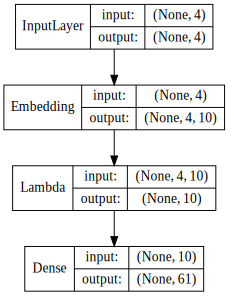

In [37]:
# visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(cbow, show_shapes = True, show_layer_names=False, dpi = 70, 
                 rankdir = 'TB').create(prog = 'dot', format ='svg'))

We have input context words of dimensions `V x N` (`2 x window_size`), we will pass them to an embedding layer of size `(vocab_size x embed_size)` which will give us dense word embeddings for each of these context words `(1 x embed_size for each word)`. 

We compare this with the actual target word, compute the `loss`, `backpropagate` the errors to adjust the weights (in the embedding layer) and repeat this process for all (context, target) pairs for multiple epochs.

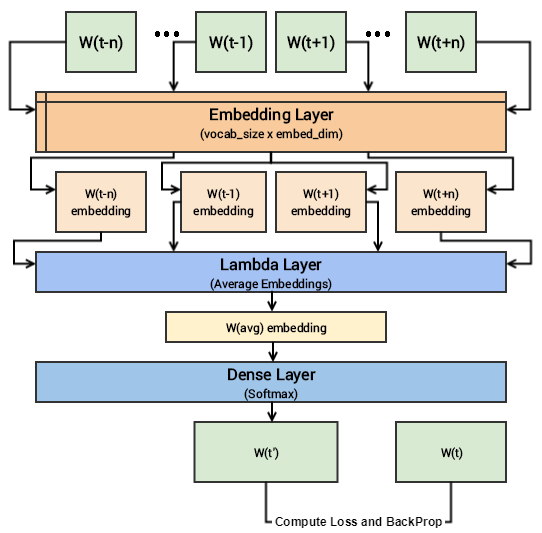

In [38]:
display(Image(r"C:\Users\Admin\Desktop\Nhan_pro\Data\cbow.png", width=690, height=400, unconfined=True))

![cbow.png](cbow.png)

link: https://github.com/Nhan121/Kaggle-6-first-projects/blob/master/NLP_Text_Classification/image_illustration/cbow.png

In [39]:
weights = cbow.get_weights()[0]
weights = weights[1:]
print(weights.shape)

pd.DataFrame(weights, index=list(id_word.values())[1:]).head()

(60, 10)


,0,1,2,3,4,5,6,7,8,9
is,0.016374,-0.014322,-0.005712,-0.017625,0.035299,-0.043018,0.010757,-0.011466,0.019159,0.049869
this,-0.023159,-0.022306,-0.035548,-0.035271,-0.019866,0.041361,-0.037700,-0.023062,0.017496,0.033480
document,0.034384,0.042061,0.025708,0.048929,-0.018929,-0.026459,-0.021748,-0.011505,-0.015332,0.014108
and,-0.030579,0.001208,0.030153,0.000730,0.010112,0.047483,-0.011834,-0.045395,-0.008348,-0.036018
earth,-0.035756,-0.021383,0.002778,0.015716,0.018819,0.020379,0.037985,0.024450,0.006182,0.020792


In [40]:
from sklearn.metrics.pairwise import euclidean_distances

# compute pairwise distance matrix
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

# view contextually similar words
similar_words = {search_term: [id_word[idx] for idx in distance_matrix[word_index[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['god', 'documents', 'we']}

pd.DataFrame(similar_words)

(60, 60)


,god,documents,we
0,is,place,problem
1,fat,all,this
2,first,lazy,unto
3,on,first,her
4,awesome,ball,fat


### 2.2. `Skip-gram` model

The `skip-gram model` is introduced in Mikolov et al. (2013a,b). Figure 3 shows the skipgram model. It is the opposite of the `CBOW` model. The `target word` is now at the `input layer`, and the `context words` are on the `output layer`.

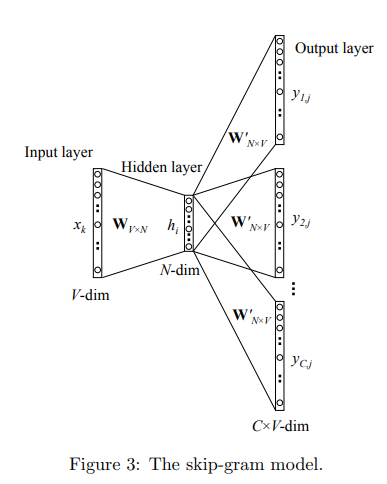

In [41]:
display(Image(r"C:\Users\Admin\Desktop\Nhan_pro\Data\skip-gram.png", width=450, unconfined=True))

Hence, in `skip gram` architecture of `word2vec`, the `input` is the `center word` and the `predictions` are the context words. For example; when the `sliding window_size = 2` then the array of words `W`, if `W(i)` is a `input` (center word), then `W(i-2), W(i-1), W(i+1), and W(i+2)` are the `context words`.

------------------------------------------------

#### Build a skip-gram [(target, context), relevancy] generator

`Keras` has a `nifty skipgrams utility` which can be used and we don’t have to manually implement this `generator` like we did in `CBOW`.

------------------------------------------------

**Note:** The function `skipgrams` *transforms a sequence of word indexes (list of integers) into tuples of words of the form*:
- (word, word in the same window), with label 1 (positive samples).
- (word, random word from the vocabulary), with label 0 (negative samples).

In [42]:
from keras.preprocessing.sequence import skipgrams

# generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10) for wid in wids]
print('pair_index: \n', skip_grams[0][0])
print('labels: \n', skip_grams[0][1])

pair_index: 
 [[21, 18], [20, 8], [18, 17], [19, 1], [17, 18], [22, 18], [16, 20], [15, 8], [20, 60], [18, 15], [15, 19], [8, 28], [17, 4], [19, 8], [21, 56], [14, 22], [8, 27], [19, 8], [8, 15], [16, 21], [1, 20], [20, 1], [15, 16], [21, 10], [21, 9], [8, 22], [17, 20], [16, 54], [1, 14], [15, 1], [20, 22], [21, 14], [8, 39], [17, 16], [17, 22], [8, 33], [15, 6], [16, 1], [18, 2], [16, 17], [14, 1], [22, 20], [22, 18], [8, 16], [1, 25], [14, 8], [14, 20], [15, 59], [19, 21], [15, 14], [20, 30], [19, 3], [18, 1], [15, 21], [16, 33], [21, 22], [22, 32], [17, 25], [14, 2], [20, 17], [17, 36], [17, 8], [17, 21], [15, 13], [22, 19], [19, 2], [17, 1], [18, 20], [22, 27], [1, 47], [16, 19], [16, 7], [22, 47], [18, 22], [1, 17], [14, 51], [15, 21], [20, 16], [19, 12], [8, 17], [18, 50], [14, 34], [21, 55], [19, 18], [14, 22], [8, 21], [21, 4], [15, 16], [19, 16], [20, 21], [14, 55], [16, 8], [14, 19], [17, 14], [16, 12], [20, 2], [22, 58], [8, 45], [20, 42], [15, 13], [14, 21], [22, 8], [15, 

In [43]:
# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(10):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          id_word[pairs[i][0]], pairs[i][0], 
          id_word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(unit (21), consider (18)) -> 1
(on (20), of (8)) -> 1
(consider (18), we (17)) -> 1
(firstly (19), the (1)) -> 1
(we (17), consider (18)) -> 1
(ball (22), consider (18)) -> 0
(generality (16), on (20)) -> 1
(loss (15), of (8)) -> 1
(on (20), documents (60)) -> 0
(consider (18), loss (15)) -> 0


    Thus you can see we have successfully generated our required skip-grams and based on the sample skip-grams in the preceding output, you can clearly see what is relevant and what is irrelevant based on the label (0 or 1).
    
### Summarization

|                    |                                  |                                                                          ------------------- CBOW model -------------                                                                          |                                             skip gram model                                             |
|:------------------:|:--------------------------------:|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|:-------------------------------------------------------------------------------------------------------:|
|     Input layer    |                                  |                                                                                      1 or multi contexts                                                                                       |                                                1 context                                                |
|    Hidden layer    |                                  |                                                                 $\textbf{h} = C^{-1} \sum_{i=1}^C \textbf{v}_{\textbf{w}_i}^T$                                                                 |                                $\textbf{h} = \textbf{v}_{\textbf{w}_I}^T$                               |
|    Output layer    |                                  |                                                                             $y_j = \dfrac{e^{u_j}}{\sum e^{u_k} }$                                                                             |                              $y_j = \dfrac{e^{u_{c,j}}}{\sum_k e^{u_{k}} }$                             |
|                    |                                  |                                                                        where $u_k = \textbf{v}'_{\text{w}_j} \textbf{h}$                                                                       |                       where $u_{c,j} = u_j = \textbf{v}'_{\text{w}_j} \textbf{h}$                       |
|                    |                                  |                                                                                                                                                                                                | with $\text{w}_j$ is the word $j^{th}$ of vocab $\text{w}_j$-the column of the (hidden --> output) $W'$ |
|    Loss function   |                                  |                                      $E = -\textbf{v}_{\textbf{w}_\text{O}} \textbf{h} - \log \sum_{k=1}^V \exp \left( \textbf{w}_k^T \textbf{h} \right) $                                     |         $E:= -\sum_{c=1}^C u_{j_c^{*}} + C \log \sum_{k=1}^V \exp \left( \textbf{u}_k \right) $         |
| Update  using  SGD |  matrix weights  of input-hidden | $\textbf{v}_{\textbf{w}_{\text{Input, c}}}^{\text{(new)}'} = \textbf{v}_{\textbf{w}_{\text{Input, c}}}^{\text{(old)}'} - \eta C^{-1}\sum_{i=1}^{V}\left(y_{j}-t_{j}\right)\text{w}'_{ij}x_{k}$ |                                                                                                         |
|                    |  matrix weights of hidden-output |                       $\textbf{v}'_{\textbf{w}_{j\left(\text{new}\right)}} = \textbf{v}'_{\textbf{w}_{j\left(\text{old}\right)}}-\eta\left(y_{j}-t_{j}\right)\textbf{h}.$                      |                                                                                                         |
|                    |                                  |                                                                                                                                                                                                |                                                                                                         |

Both have their own advantages and disadvantages. 

- According to Mikolov, `Skip Gram` works well with `small amount of data` and is found to `represent rare words` well.

- On the other hand, `CBOW` is `faster and has better representations for more frequent words`.

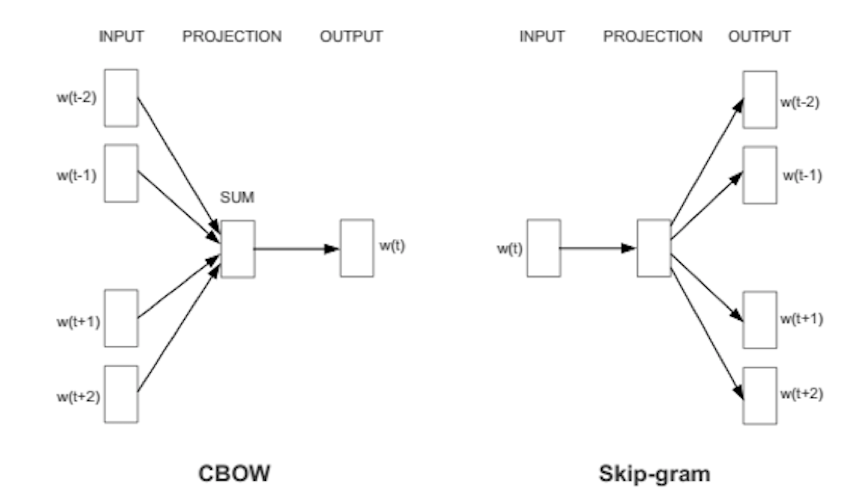

In [44]:
display(Image(r"C:\Users\Admin\Desktop\Nhan_pro\Data\word2vec.png", width=650, unconfined=True))

## 3. `Word2Vec` & `GloVe`

Now, we study directly the supported libraries and packages of them.

### 3.1 Word Embedding with `Word2Vec`

`word2vec` is an `unsupervised` method based on the idea that `similar words` have `similar neighbors`. There are 2 main approaches for training `word2vec` models : `CBOW (continuous bag of words)` and `Skip-Grams`. 

In both cases, we consider a fixed `size word window` which you slide across the text. 
- In case of `CBOW`, the model is trained to *predict the current words given its neighbors in the window*, and 
- In `skip-gram`, the model predicts the *surrounding words in the window given the current word*.

----------------------------------------

The words are `input` to the model as `1-hot encoded vectors`, where the size of the vector is the size of the vocabulary. WE can control the size of the vocabulary by setting a minimum frequency, considering only top N words by frequency, etc. 

Output is a fixed size dense vector, where the size is the embedding size you select for your model. The model itself is a fully connected network, with one or more hidden layers. 

Once your model reaches the desired level of accuracy, you remove the final layer and run your sparse word vectors through the truncated network to get your embeddings.

Using `gensim.model`, now we can work conveniently with `Word2Vec`.

https://radimrehurek.com/gensim/models/word2vec.html

**Using `cosine-similarity` to evaluate the similar of a pair of word** This metric isn’t semantic distance; but tends to place two words close to each other if they occur in similar contexts; and defined by

$$ \cos \left( A, B \right) = \dfrac{A \circ B}{\Vert A \Vert_2 \Vert B \Vert_2} $$

- If two words are very close to synonymous, we will expect them to show up in similar contexts, and indeed synonymous words tend to be close.
- It’s positive when the words are close to each other, negative when the words are far.  For two completely random words, the similarity is pretty close to 0.

In python; we press `model.wv.similarity("word_A", "word_B")`

Firstly, loading dataset 

In [45]:
import gensim 
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import sent_tokenize, word_tokenize 

sample = open(r"C:\Users\Admin\Desktop\Nhan_pro\Data\ML\alice.txt", "r")
s = sample.read() 
  
# Replaces escape character with space 
f = s.replace("\n", " ") 
  
data = [] 
  
# iterate through each sentence in the file 
for i in sent_tokenize(f): 
    temp = [] 
      
    # tokenize the sentence into words 
    for j in word_tokenize(i): 
        temp.append(j.lower()) 
  
    data.append(temp) 

print('The first line of data: \n', data[0])    

unable to import 'smart_open.gcs', disabling that module


The first line of data: 
 ['alice', "'s", 'adventures', 'in', 'wonderland', 'alice', "'s", 'adventures', 'in', 'wonderland', 'lewis', 'carroll', 'the', 'millennium', 'fulcrum', 'edition', '3.0', 'chapter', 'i', 'down', 'the', 'rabbit-hole', 'alice', 'was', 'beginning', 'to', 'get', 'very', 'tired', 'of', 'sitting', 'by', 'her', 'sister', 'on', 'the', 'bank', ',', 'and', 'of', 'having', 'nothing', 'to', 'do', ':', 'once', 'or', 'twice', 'she', 'had', 'peeped', 'into', 'the', 'book', 'her', 'sister', 'was', 'reading', ',', 'but', 'it', 'had', 'no', 'pictures', 'or', 'conversations', 'in', 'it', ',', '`', 'and', 'what', 'is', 'the', 'use', 'of', 'a', 'book', ',', "'", 'thought', 'alice', '`', 'without', 'pictures', 'or', 'conversation', '?', "'"]


`Create CBOW model without load the pre-trained` 

                Word2Vec(sentences, min_count=10, size = 100, window = 5, sg = 1) 

Noting that :
- **`min_count`** Ignores all words with total frequency lower than this; its reasonable value is between `0-100` (default = 5), ***depending on the size of your dataset***.
- **`size = 100`** is size of the `NN layers`, which correspond to the `“degrees” of freedom` the training algorithm has. A bigger size values require more training data, but can lead to better (more accurate) models. Reasonable values are in the tens to hundreds.
- **`window = 5`**: size of `context_window` or the maximum distance between the `current` and `predicted` word `within a sentence`
- **`sg = {0, 1}`** Training algorithm: `1 for skip-gram`; `otherwise CBOW`.

In [46]:
model1 = Word2Vec(data, min_count = 1, size = 100, window = 10) 
  
model2 = Word2Vec(data, min_count = 1, size = 100, window = 10, sg = 1) 

## display
print("Cosine similarity between 'alice' " + "and 'wonderland' - CBOW : ", model1.wv.similarity('alice', 'wonderland')) 
      
print("Cosine similarity between 'alice' " + "and 'machines' - CBOW : ",  model1.wv.similarity('alice', 'machines')) 
  
print("Cosine similarity between 'alice' " + "and 'wonderland' - Skip Gram : ", model2.wv.similarity('alice', 'wonderland')) 
      
print("Cosine similarity between 'alice' " + "and 'machines' - Skip Gram : ", model2.wv.similarity('alice', 'machines'))

Cosine similarity between 'alice' and 'wonderland' - CBOW :  0.99826735
Cosine similarity between 'alice' and 'machines' - CBOW :  0.9911171
Cosine similarity between 'alice' and 'wonderland' - Skip Gram :  0.91983867
Cosine similarity between 'alice' and 'machines' - Skip Gram :  0.91821283


**The most similar words**

In [47]:
model1.wv.most_similar('deep')

[('came', 0.999174177646637),
 ('rather', 0.9991662502288818),
 ('moment', 0.9991574287414551),
 ('again', 0.9991551041603088),
 ('in', 0.9991456270217896),
 ('were', 0.9991435408592224),
 ('now', 0.9991378784179688),
 ('their', 0.9991366863250732),
 ('head', 0.9991320371627808),
 ('them', 0.9991269111633301)]

In [48]:
len(list(model1.wv.vocab))

2625

We can see that `cosine similarity` is not sementic distance. In this model's dataset, the words `deep` and `away` are understood as a `synonym`; since both words are likely to occur in contexts where we’re talking about `distance`. 

Because this model only contained 2625 vocabularies, hence the result isn't what we expected.

Now, we try to Load **`Google’s Word2Vec Embedding`**

Training your own word vectors may be the best approach for a given NLP problem.

But it can take a long time, a fast computer with a lot of RAM and disk space, and perhaps some expertise in finessing the input data and training algorithm.

An alternative is to simply use an existing pre-trained word embedding.

Along with the paper and code for word2vec, Google also published a pre-trained word2vec model on the Word2Vec Google Code Project.

A pre-trained model is nothing more than a file containing tokens and their associated word vectors. The pre-trained Google word2vec model was trained on Google news data (about 100 billion words); it contains 3 million words and phrases and was fit using 300-dimensional word vectors.

The `Gensim library` provides tools to load this file. Specifically, you can call the `KeyedVectors.load_word2vec_format()` function to load this model into memory.

In [49]:
from gensim.models import KeyedVectors
filename = r"D:\Nhan\GoogleNews-vectors-negative300.bin\GoogleNews-vectors-negative300.bin"
model = KeyedVectors.load_word2vec_format(filename, binary=True)

In [50]:
model.most_similar('deep')

[('deeper', 0.6928303241729736),
 ('deepest', 0.6820540428161621),
 ('depths', 0.5342872142791748),
 ('shallow', 0.527501106262207),
 ('gravelly_voice_fills', 0.5268532633781433),
 ('Deep', 0.5056449174880981),
 ('depth', 0.4998552203178406),
 ('deepening', 0.4924544095993042),
 ('Deeper', 0.49067163467407227),
 ('water_newbuilding_drillships', 0.48911160230636597)]

Another interesting thing that you can do is do a little linear algebra arithmetic with words.

For example, a popular example described in lectures and introduction papers `queen = (king - man) + woman`. That is the word queen is the closest word given the subtraction of the notion of man from king and adding the word woman. 

The `“man-ness”` in king is replaced with `“woman-ness”` to give us `queen`. A very cool concept.

`Gensim` provides an interface for performing these types of operations in the `most_similar()` function on the trained or loaded model.

In [51]:
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)

[('queen', 0.7118192911148071)]


This meant calculating the `(king – man) + woman = ?` operation on the word vectors for those words then the answer, as we would expect, `is queen` with a `cosine_similarity_distance` is about `0.712`.

**Using `get_tmpfile` to initialize a model by load another pre-trained model**

In [52]:
from gensim.test.utils import common_texts, get_tmpfile
path = get_tmpfile("word2vec.model")

## The training is streamed, meaning sentences can be a generator, reading input data from disk on-the-fly, 
## without loading the entire corpus into RAM.
model = Word2Vec(common_texts, size=100, window=5, min_count=1, workers=4)
model

`saving; loading and training with a word_vector of a list of list 3 words: "hello", "world", "Python"` and `"married", "love", "wedding"`

**Describe params.** 
                    
     Word2Vec.train(sentences, total_examples, total_words, epochs, start_alpha, end_alpha, word_count, report_delay)
     
where:
- **`total_examples`**: `count of sentences`; while `total_words` be the `count of raw words in sentences`.
- **`epochs`** Number of iterations (epochs) over the corpus.
- **`start_alpha`** Initial learning rate. If supplied, replaces the starting `alpha` from the constructor, for this one call to `train()`. Use only if making multiple calls to `train()`, when you want to manage the alpha learning-rate yourself **`(not recommended)`**.
- **`end_alpha`** : Final learning rate. Drops linearly from `start_alpha`. If supplied, this replaces the final `min_alpha` from the constructor, for this one call to `train()`. Use only if making multiple calls to `train()`, when you want to manage the alpha learning-rate yourself **`(not recommended)`**.
- **`word_count`**: Count of words already trained. Set this to 0 for the usual case of training on all words in sentences.
- **`report_delay`**: Seconds to wait before reporting progress

In [53]:
model.save("word2vec.model")

sentences = [["hello", "world", "python"], ["married", "love", "wedding"]]

## load
model = Word2Vec.load("word2vec.model")
model.train(sentences, total_examples=1, epochs=1)

(0, 6)

the second values in the output is proportional to the `epochs` values

In [54]:
model.train(sentences, total_examples=1, epochs=9)

(0, 54)

However, if we initialize a `non pre-trainned` model, then change `total_examples = new_model.corpus_count` and `epochs = new_model.epochs`; we receive the

In [55]:
model.train(sentences, total_examples = model.corpus_count, epochs = model.epochs)  # train word vectors

(0, 54)

The trained word vectors are stored in a `KeyedVectors` instance in `model.wv`:

In [56]:
vector = model.wv['computer']  # numpy vector of a word
print('word-vector :', vector)
print('shape :', vector.shape)

word-vector : [ 4.6374695e-03  3.8004338e-03  3.9516883e-03  3.0571078e-03
  3.0187371e-03  1.3688032e-03  8.2205472e-05 -1.7625822e-03
 -1.0712222e-03  5.6733604e-04  2.3015589e-03 -1.9375277e-03
  1.9433218e-03 -1.6468958e-03  1.2422104e-03  3.8283681e-03
  1.2573547e-04 -3.6531506e-04 -2.9098275e-03 -4.4494984e-03
  2.1532997e-03  3.9021450e-04 -3.5824541e-03 -4.9733664e-03
  2.7548305e-03 -1.6873782e-03  4.8454395e-03  4.9152020e-03
  1.1316553e-03  5.7840900e-04 -4.4945152e-03 -1.2906215e-03
  1.0511394e-03  4.5608459e-03  1.7331257e-03  2.1293822e-03
 -4.0510092e-03  1.8281363e-03  4.9793157e-03 -2.5910109e-03
  2.5926996e-03 -1.4593911e-03 -2.0880715e-03 -1.2196095e-03
 -1.5261088e-03  1.0013124e-03 -4.1133119e-03 -4.4411663e-03
 -4.8677982e-03 -3.8316811e-03 -2.4052897e-05  1.1891911e-03
 -7.1668159e-04  2.2617027e-03  4.6161106e-03 -3.0584345e-04
 -2.5558150e-03  2.8921210e-03 -4.8195859e-04 -3.8402143e-03
 -1.1130279e-03 -3.6406587e-03  6.4178283e-04 -3.2462596e-03
  4.362916

The reason for separating the trained vectors into `KeyedVectors` is that if you don’t need the full model state any more (don’t need to continue training), the state can discarded, resulting in a much smaller and faster object that can be mmapped for lightning fast loading and sharing the vectors in RAM between processes:

In [57]:
path = get_tmpfile("wordvectors.kv")
model.wv.save(path)
model.wv = KeyedVectors.load(path, mmap='r')
vector = model.wv['computer']  # numpy vector of a word
print('word-vector :', vector)
print('shape :', vector.shape)

word-vector : [ 4.6374695e-03  3.8004338e-03  3.9516883e-03  3.0571078e-03
  3.0187371e-03  1.3688032e-03  8.2205472e-05 -1.7625822e-03
 -1.0712222e-03  5.6733604e-04  2.3015589e-03 -1.9375277e-03
  1.9433218e-03 -1.6468958e-03  1.2422104e-03  3.8283681e-03
  1.2573547e-04 -3.6531506e-04 -2.9098275e-03 -4.4494984e-03
  2.1532997e-03  3.9021450e-04 -3.5824541e-03 -4.9733664e-03
  2.7548305e-03 -1.6873782e-03  4.8454395e-03  4.9152020e-03
  1.1316553e-03  5.7840900e-04 -4.4945152e-03 -1.2906215e-03
  1.0511394e-03  4.5608459e-03  1.7331257e-03  2.1293822e-03
 -4.0510092e-03  1.8281363e-03  4.9793157e-03 -2.5910109e-03
  2.5926996e-03 -1.4593911e-03 -2.0880715e-03 -1.2196095e-03
 -1.5261088e-03  1.0013124e-03 -4.1133119e-03 -4.4411663e-03
 -4.8677982e-03 -3.8316811e-03 -2.4052897e-05  1.1891911e-03
 -7.1668159e-04  2.2617027e-03  4.6161106e-03 -3.0584345e-04
 -2.5558150e-03  2.8921210e-03 -4.8195859e-04 -3.8402143e-03
 -1.1130279e-03 -3.6406587e-03  6.4178283e-04 -3.2462596e-03
  4.362916

Comeback the pre-trained model

                    model = KeyedVectors.load_word2vec_format(filename, binary=True)

if we don't want to use this; we can initialize then train the `text_data`

                    model = Word2Vec(min_count = 20,
                                         window = 2,
                                         size = 300,
                                         sample= 6e-5, 
                                         alpha = 0.03, 
                                         min_alpha = 0.0007, 
                                         negative = 20,
                                         workers = 2)
                    model.build_vocab(data, progress_per = 10000)
                    model.train(data, total_examples = model.corpus_count, epochs=30, report_delay=1)

In [66]:
model = KeyedVectors.load_word2vec_format(filename, binary=True)

**Using `Word2Vec` to explore the `positive-similar` words of `"the"`**

In [59]:
model.init_sims(replace=True)
model.most_similar(positive=["the"])

[('this', 0.5937378406524658),
 ('in', 0.5429296493530273),
 ('that', 0.5262569785118103),
 ('ofthe', 0.515028178691864),
 ('another', 0.47483524680137634),
 ('however', 0.4748331904411316),
 ('one', 0.4665869474411011),
 ('entire', 0.46198248863220215),
 ('its', 0.460594117641449),
 ('which', 0.4595310688018799)]

**Build a `scatterplot` of the similar word by using `t-SNE`**

Reference `t-SNE`:
https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

mygithub

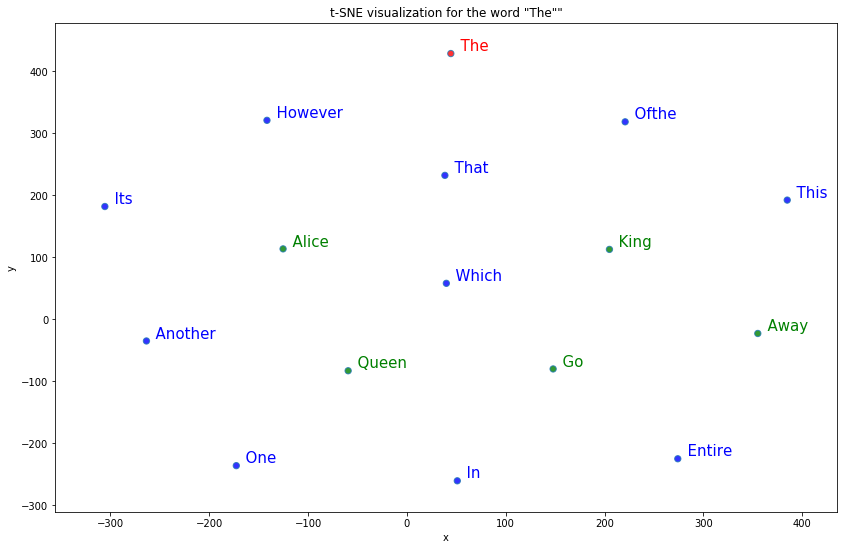

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.__getitem__([wrd_score[0]])    ## using either model.wv__getitem__ or model.__getitem__
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=10).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(14, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for the word "{}""'.format(word.title()))
    
tsnescatterplot(model, 'the', ['king', 'queen', 'alice', 'go', 'away'])

The Word to Vec model produces a vocabulary, with each word being represented by an n-dimensional numpy array (100 values in this example)

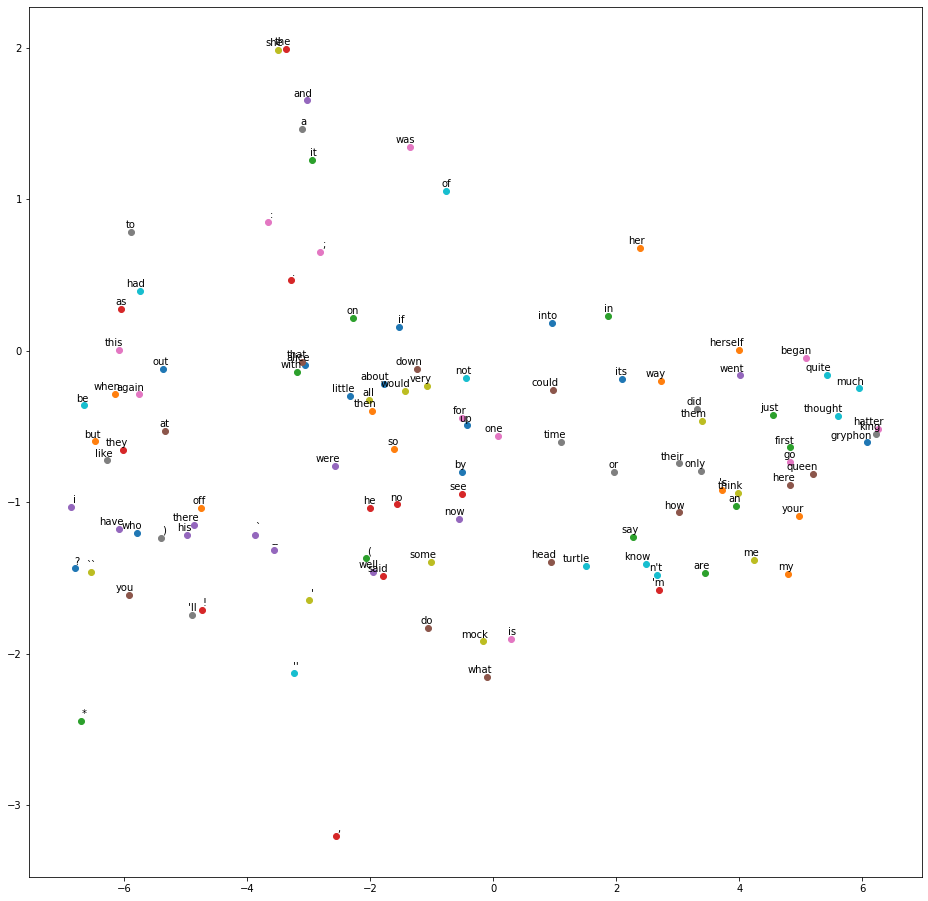

In [68]:
# model = KeyedVectors.load_word2vec_format(filename, binary=True)
new_model = Word2Vec(data, size=100, window=20, min_count=50, workers=4)

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity = 40, n_components = 2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

tsne_plot(new_model)

### 3.2. Glove Embedding

After Tomas Mikolov et al. released the word2vec tool, there was a boom of articles about word vector representations. One of the best of these articles is `Stanford’s GloVe`: `Global Vectors for Word Representation`, which explained why such algorithms work and reformulated word2vec optimizations as a special kind of factoriazation for word `co-occurence matrices`.

Ref: https://www.coursera.org/lecture/nlp-sequence-models/glove-word-vectors-IxDTG


http://text2vec.org/glove.html

## 4. Using `Keras Embedding layers`

https://stackoverflow.com/questions/42762849/keras-embedding-layers-how-do-they-work

### 4.1. Something about `Keras Embedding layers`

### 4.2 Using `TfidfVectorizer` in `keras`

### 4.3. Using `onehot_encode` in `keras`

### 4.4. Using `GloVe` in `keras`

### 4.5. Using `word2vec` in `keras`

In [69]:
sentences = [['this', 'is', 'the', 'first', 'sentence', 'for', 'word2vec'],
             ['this', 'is', 'the', 'second', 'sentence'],
            ['yet', 'another', 'sentence'],
            ['one', 'more', 'sentence'],
            ['and', 'the', 'final', 'sentence']]
# train model
model = Word2Vec(sentences, min_count=1)
# summarize the loaded model
print(model)
# summarize vocabulary
words = list(model.wv.vocab)
print(words)
# access vector for one word
print(model.wv['sentence'])
# save model
model.save('model.bin')
# load model
new_model = Word2Vec.load('model.bin')
print(new_model)

Word2Vec(vocab=14, size=100, alpha=0.025)
['this', 'is', 'the', 'first', 'sentence', 'for', 'word2vec', 'second', 'yet', 'another', 'one', 'more', 'and', 'final']
[-0.00015893  0.00287407 -0.00426507 -0.00423382 -0.00306007 -0.00222442
 -0.00303092 -0.00112493 -0.0032701  -0.00221968  0.00281707 -0.00496206
 -0.00191959  0.00446632 -0.00410913  0.00296664  0.0037364  -0.00449985
 -0.001058    0.00011125 -0.00255899  0.00314805 -0.00417091 -0.00420754
  0.00106403 -0.00397521 -0.00137095 -0.00096702 -0.00453471 -0.00200761
  0.00478932 -0.00114659  0.00128061 -0.00088818 -0.00148076  0.00129967
  0.00159002  0.00115354  0.00365708  0.00339411 -0.00120659  0.00414635
 -0.00367501 -0.00374393  0.00396464 -0.00485322 -0.0033033   0.00000419
 -0.00014421 -0.00458221  0.00099943 -0.00183815 -0.00148023  0.00150522
  0.00025621 -0.00350808  0.00475423  0.00197863  0.00256623 -0.00107192
 -0.00444032  0.00033437  0.00341899  0.00413578  0.00192679  0.00206821
 -0.00457029  0.00312194  0.002144

#### References:

1 https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

2 https://www.coursera.org/lecture/nlp-sequence-models/glove-word-vectors-IxDTG

3 https://radimrehurek.com/gensim/models/word2vec.html